In [1]:
from classes import Team

from itertools import product

import pandas as pd
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl

In [2]:
names = {
    "FCB": "Bayern München",
    "B04": "B. Leverkusen",
    "SGE": "E. Frankfurt",
    "BVB": "Bor. Dortmund",
    "SCF": "SC Freiburg",
    "M05": "1.FSV Mainz 05",
    "RBL": "RB Leipzig",
    "SVW": "Werder Bremen",
    "VFB": "VfB Stuttgart",
    "BMG": "Bor. M'gladbach",
    "WOB": "VfL Wolfsburg",
    "FCA": "FC Augsburg",
    "FCU": "Union Berlin",
    "STP": "FC St. Pauli",
    "TSG": "TSG Hoffenheim",
    "HDH": "1.FC Heidenheim",
    "KOE": "1.FC Köln",
    "HSV": "Hamburger SV",
    "BSC": "Hertha BSC"
}

In [3]:
home_team = names["SGE"]
away_team = names["M05"]

In [4]:
l_home, l_away = 1.7626230692801013, 1.1957667178514437

In [5]:
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.constrained_layout.use"] = True
mpl.rcParams["figure.frameon"] = False
mpl.rcParams["font.sans-serif"] = ["Lexend"] + mpl.rcParams["font.sans-serif"]
mpl.rcParams["legend.framealpha"] = 1.0

In [6]:
df = pd.read_csv("model.csv")
df.head(18)

,name,attack,defense
0,Bayern München,27.217188,19.881103
1,Bor. Dortmund,17.603421,15.844049
2,B. Leverkusen,17.372356,15.217217
3,RB Leipzig,14.947129,14.779552
4,E. Frankfurt,17.346145,10.290514
5,VfB Stuttgart,14.979101,12.429299
6,1.FSV Mainz 05,9.760085,11.638049
7,Werder Bremen,11.128696,10.158885
8,TSG Hoffenheim,13.755247,6.612772
9,SC Freiburg,8.737281,11.351355


In [7]:
teams = {}
for index, row in df.iterrows():
    name = row["name"]
    att = row["attack"]
    dfe = row["defense"]

    teams[name] = Team(name, att, dfe)

In [8]:
prediction = teams[home_team].match(teams[away_team], l_home, l_away)

print(*prediction)

2.315122621797527 1.1643447043834423


In [9]:
def poisson(k, l):
    return l**k / factorial(k, exact=True) * np.exp(-l)

In [10]:
p = teams[home_team].calculate_win_probabilities(teams[away_team], l_home, l_away)

print(*[f"{100*r:.3}%" for r in p])

63.1% 19.0% 17.9%


In [11]:
results = []
for h, a in product(range(0, 6), repeat=2):
    results.append((h, a, poisson(h, prediction[0])*poisson(a, prediction[1])))

In [12]:
results.sort(key=lambda x: x[-1], reverse=True)

In [13]:
print(*[f"{r[0]}:{r[1]}  {100*r[2]:.3}%" for r in results[:10]], sep="\n")

2:1  9.62%
1:1  8.31%
2:0  8.26%
3:1  7.42%
1:0  7.14%
3:0  6.37%
2:2  5.6%
1:2  4.84%
3:2  4.32%
4:1  4.3%


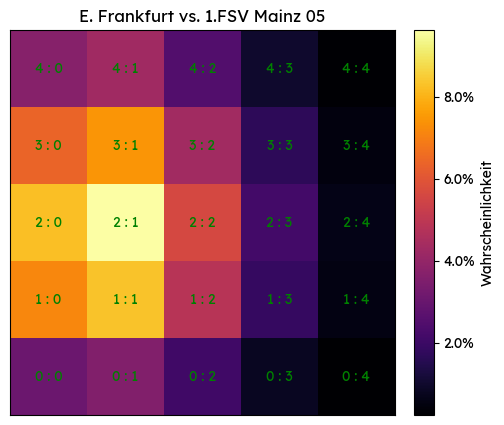

In [14]:
teams[home_team].show_probability_distribution(teams[away_team], l_home ,l_away, save=True)

In [15]:
N = 5
M = 6

results = np.zeros((M, M))

for i in range(M):
    for j in range(M):
        results[i, j] = poisson(i, prediction[0])*poisson(j, prediction[1])

points = np.zeros((N, N))
point_list = []

for i in range(N):
    for j in range(N):
        poi = np.zeros((M, M))
        for a in range(M):
            for b in range(M):
                if i == a and j == b:
                    poi[a, b] = 4
                elif (i-j) == (a-b):
                    poi[a, b] = 3
                elif i > j and a > b:
                    poi[a, b] = 2
                elif i < j and a < b:
                    poi[a, b] = 2

        points[i, j] = np.sum(results * poi)
        point_list.append((i, j, np.sum(results * poi)))

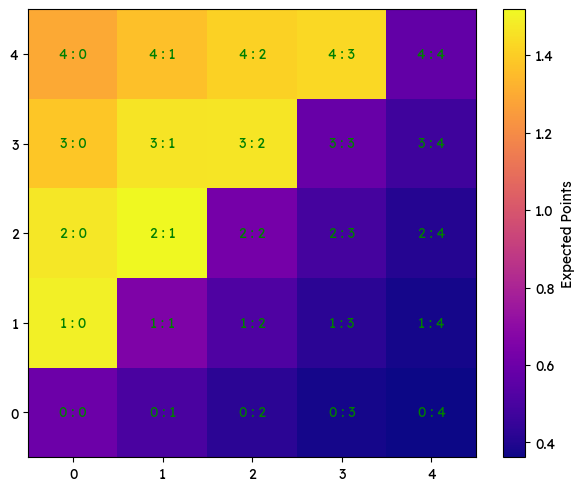

In [16]:
heatmap = plt.imshow(points, cmap='plasma', origin="lower")
cb = plt.colorbar(heatmap, label='Expected Points')

font_props = {"ha": "center",
              "va": "center",
              "color": "g"}

for i in range(N):
    for j in range(N):
        plt.text(j, i, f'{i} : {j}', **font_props)

plt.show()

In [17]:
point_list.sort(key=lambda x: x[-1], reverse=True)

print(*[f"{p[0]}:{p[1]}  {p[2]:.4}" for p in point_list[:10]], sep="\n")

2:1  1.518
1:0  1.494
2:0  1.469
3:2  1.465
3:1  1.461
4:3  1.432
4:2  1.412
3:0  1.383
4:1  1.362
4:0  1.294
